In [1]:
from src.nf import NormalizingFlowModel, MAF, CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf
from utils import data_utils

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

from copy import deepcopy

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = data_utils.GAS()

In [5]:
dim = data.n_dims

In [6]:
X_train_tensor = torch.from_numpy(data.trn.x[:1000]).to(device)
X_test_tensor = torch.from_numpy(data.tst.x[:1000]).to(device)

In [7]:
prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = NormalizingFlowModel(dim, prior, [MAF(dim), MAF(dim)]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [8]:
epoches = 100
metrics_train, metrics_test = [], []

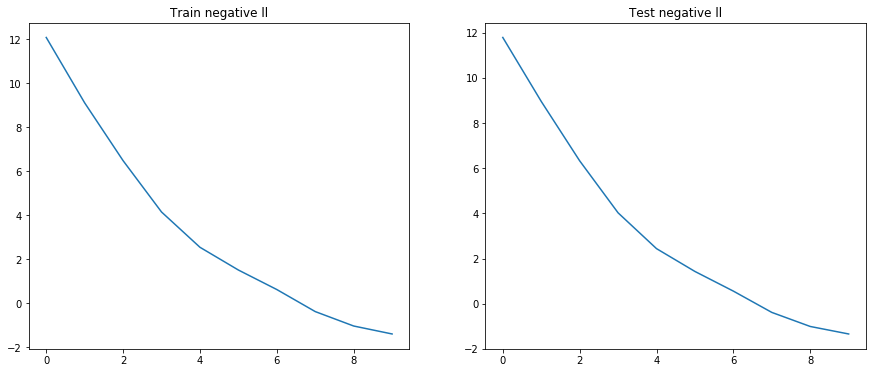

In [9]:
for epoch in range(len(metrics_train), epoches):
    loss = model.ll_train_step(optimizer, X_train_tensor)

    if epoch % 10 == 0:
        metrics_train.append(neg_log_likelihood(model, X_train_tensor))
        metrics_test.append(neg_log_likelihood(model, X_test_tensor))
        
        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        axs[0].plot(np.arange(len(metrics_train)), metrics_train)
        axs[0].set_title('Train negative ll')
        axs[1].plot(np.arange(len(metrics_test)), metrics_test)
        axs[1].set_title('Test negative ll')

    plt.show()

In [12]:
clf_ds, clf = train_catboost_clf(X_train_tensor, model, {'iterations': 100})

Learning rate set to 0.114413
0:	learn: 0.6663966	total: 2.45ms	remaining: 243ms
1:	learn: 0.6452350	total: 4.95ms	remaining: 243ms
2:	learn: 0.6283769	total: 7.28ms	remaining: 235ms
3:	learn: 0.6146821	total: 9.8ms	remaining: 235ms
4:	learn: 0.6016250	total: 11.7ms	remaining: 221ms
5:	learn: 0.5898008	total: 14ms	remaining: 219ms
6:	learn: 0.5812764	total: 16.4ms	remaining: 218ms
7:	learn: 0.5735698	total: 18.6ms	remaining: 214ms
8:	learn: 0.5672082	total: 20.8ms	remaining: 210ms
9:	learn: 0.5608619	total: 22.8ms	remaining: 205ms
10:	learn: 0.5531691	total: 24.8ms	remaining: 201ms
11:	learn: 0.5470340	total: 26.9ms	remaining: 198ms
12:	learn: 0.5415507	total: 28.5ms	remaining: 190ms
13:	learn: 0.5348541	total: 30.2ms	remaining: 185ms
14:	learn: 0.5305503	total: 31.7ms	remaining: 179ms
15:	learn: 0.5256445	total: 33.2ms	remaining: 174ms
16:	learn: 0.5208166	total: 35.6ms	remaining: 174ms
17:	learn: 0.5168482	total: 37.9ms	remaining: 173ms
18:	learn: 0.5136209	total: 40.4ms	remaining: 1

In [13]:
calibrated_model = CalibratedModel(clf, model, logit=True)

In [14]:
samples = model.sample_n(1000)
new_samples = calibrated_model.sample_n(1000)

In [15]:
-neg_log_likelihood(model, samples), \
-neg_log_likelihood(calibrated_model, new_samples)


(1.4879695177078247, 2.569898570987151)